In [1]:
# Colab: block 1 - imports + load files
import random
import math
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip
from tqdm import trange, tqdm

# File paths - in Colab if you upload, adjust paths; here we use the provided upload paths.
CORPUS_PATH = 'corpus.txt'
TEST_PATH   = 'test.txt'

# Load corpus and test into memory
def load_wordlist(path, lowercase=True):
    words = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            w = line.strip()
            if not w:
                continue
            if lowercase:
                w = w.lower()
            # keep only pure ascii letters (optional) but allow hyphenless words
            w = ''.join(ch for ch in w if ch.isalpha())
            if w:
                words.append(w)
    return words

corpus = load_wordlist(CORPUS_PATH)
testset = load_wordlist(TEST_PATH)

print(f'Corpus words: {len(corpus)}  (sample: {corpus[:5]})')
print(f'Test words:   {len(testset)}  (sample: {testset[:5]})')

# quick basic stats
max_len = max(len(w) for w in corpus)
min_len = min(len(w) for w in corpus)
print(f'Word lengths in corpus: min={min_len} max={max_len}')

# citations to confirm we used the provided files (for your report)
print("Problem statement and datasets used from uploaded files. See Problem_Statement.pdf and corpus/test files. :contentReference[oaicite:5]{index=5} :contentReference[oaicite:6]{index=6} :contentReference[oaicite:7]{index=7}")


Corpus words: 50000  (sample: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly'])
Test words:   2000  (sample: ['marmar', 'janet', 'dentistical', 'troveless', 'unnotify'])
Word lengths in corpus: min=1 max=24
Problem statement and datasets used from uploaded files. See Problem_Statement.pdf and corpus/test files. :contentReference[oaicite:5]{index=5} :contentReference[oaicite:6]{index=6} :contentReference[oaicite:7]{index=7}


In [2]:
# Colab: block 2 - build positional model + candidate filtering

# Precompute positional letter counts per word-length
pos_counts = {}   # pos_counts[length][pos] -> Counter of letters
length_buckets = defaultdict(list)
for w in corpus:
    length_buckets[len(w)].append(w)

for L, words in length_buckets.items():
    pos_counts[L] = [Counter() for _ in range(L)]
    for w in words:
        for i,ch in enumerate(w):
            pos_counts[L][i][ch] += 1

# Simple additive-smoothed probability function for a given length and position
ALPHA = 1.0
alphabet = [chr(ord('a')+i) for i in range(26)]

def positional_prob(length, pos, letter):
    """Return P(letter | length, pos) with additive smoothing."""
    if length not in pos_counts or pos < 0 or pos >= len(pos_counts[length]):
        return 1.0/26.0
    c = pos_counts[length][pos][letter]
    total = sum(pos_counts[length][pos].values())
    return (c + ALPHA) / (total + ALPHA * 26)

# Candidate filtering: match masked pattern to corpus candidate words (fast)
# Improved: use wrong_letters exclusion strictly
def candidates_for_pattern(pattern, guessed, wrong_letters=None):
    if wrong_letters is None:
        wrong_letters = set()
    L = len(pattern)
    if L not in length_buckets:
        return []
    patt = pattern.lower()
    result = []
    for w in length_buckets[L]:
        # skip words containing known wrong letters
        if any(ch in w for ch in wrong_letters):
            continue
        ok = True
        for i,ch in enumerate(patt):
            if ch != '_' and w[i] != ch:
                ok = False
                break
        if ok:
            result.append(w)
    return result

def hmm_letter_distribution(pattern, guessed, wrong_letters=None):
    """
    Return a dict mapping each remaining letter -> score (probability-like) using candidate words.
    - pattern: string like '_pp_e'
    - guessed: set of letters guessed so far
    - wrong_letters: set of letters known wrong (optional)
    """
    if wrong_letters is None:
        wrong_letters = set()
    cand = candidates_for_pattern(pattern, guessed)
    L = len(pattern)
    counts = Counter()
    if cand:
        # count occurrences of letters in unknown positions across candidates
        unknown_pos = [i for i,ch in enumerate(pattern) if ch == '_']
        for w in cand:
            for i in unknown_pos:
                counts[w[i]] += 1
        total = sum(counts.values()) + 1e-9
        # build distribution over letters not already guessed
        dist = {}
        for a in alphabet:
            if a in guessed:
                dist[a] = 0.0
            elif a in wrong_letters:
                dist[a] = 0.0
            else:
                # smoothed probability from candidate counts, fallback to positional average
                dist[a] = (counts[a] + ALPHA) / (total + ALPHA*26)
        return dist, len(cand)
    else:
        # fallback to positional HMM (aggregate over positions)
        unknown_pos = [i for i,ch in enumerate(pattern) if ch == '_']
        scores = Counter()
        for i in unknown_pos:
            for a in alphabet:
                scores[a] += positional_prob(L, i, a)
        # convert to normalized dist excluding guessed
        for a in alphabet:
            if a in guessed or a in wrong_letters:
                scores[a] = 0.0
        ssum = sum(scores.values()) + 1e-9
        dist = {a: (scores[a]/ssum) for a in alphabet}
        return dist, 0

# quick sanity check
pat = '____'
d, cand_count = hmm_letter_distribution(pat, guessed=set())
print('Candidates for "____":', cand_count, 'Top letter probs:', sorted(d.items(), key=lambda x:-x[1])[:8])


Candidates for "____": 1169 Top letter probs: [('a', 0.11612079965969456), ('e', 0.08783496384515357), ('o', 0.08060399829857919), ('i', 0.06039982985962135), ('t', 0.059761803487864786), ('r', 0.054444917056560085), ('n', 0.05401956614205571), ('l', 0.05359421522755134)]


In [3]:
class HangmanEnv:
    def __init__(self, secret_word, max_wrong=6):
        self.secret = secret_word.lower()
        self.max_wrong = max_wrong
        self.reset()

    def reset(self):
        self.guessed = set()
        self.wrong = set()
        self.revealed = ['_' for _ in self.secret]
        self.wrong_count = 0
        self.done = False
        self.repeats = 0
        return self._state()

    def _state(self):
        return {
            'pattern': ''.join(self.revealed),
            'guessed': set(self.guessed),
            'lives_left': self.max_wrong - self.wrong_count
        }

    def guess(self, letter):
        letter = letter.lower()
        if self.done:
            raise RuntimeError("Game already finished")
        reward = 0.0
        if letter in self.guessed:
            self.repeats += 1
            reward = -0.5
        else:
            self.guessed.add(letter)
            if letter in self.secret:
                # count new reveals
                new_reveals = 0
                for i,ch in enumerate(self.secret):
                    if ch == letter and self.revealed[i] == '_':
                        self.revealed[i] = letter
                        new_reveals += 1
                # reward scales with info gain
                reward = 0.5 + 0.2 * new_reveals
            else:
                self.wrong.add(letter)
                self.wrong_count += 1
                reward = -1.0

        if '_' not in self.revealed:
            self.done = True
            reward += 5.0
        elif self.wrong_count >= self.max_wrong:
            self.done = True
            reward -= 2.0
        return {
            'state': self._state(),
            'reward': reward,
            'done': self.done
        }


In [4]:
# Colab: block 4 - Q-learning agent

class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.95, epsilon=0.3, eps_decay=0.9995, min_eps=0.05, mix_hmm=0.7):
        """
        mix_hmm: how strongly to prefer HMM probabilities when forming action preferences (0..1)
        """
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.min_eps = min_eps
        self.mix_hmm = mix_hmm
        # Q: dict mapping state_key -> array of length 26
        self.Q = defaultdict(lambda: np.zeros(26, dtype=np.float32))

    def state_key(self, pattern, lives_left):
        L = len(pattern)
        revealed = pattern.count('_')
        # use (length, lives_left, revealed_count) but compress revealed to number revealed
        revealed_count = len(pattern) - revealed
        # clamp lengths for table size
        Lc = min(L, 20)
        return (Lc, lives_left, revealed_count)

    def choose_action(self, pattern, guessed, hmm_dist, lives_left):
        s = self.state_key(pattern, lives_left)
        qvals = self.Q[s]  # array of 26
        # build scores combining Q and HMM
        hmm_scores = np.array([hmm_dist.get(chr(ord('a')+i), 0.0) for i in range(26)], dtype=np.float32)
        # mask already guessed letters heavily
        mask = np.array([1.0 if chr(ord('a')+i) not in guessed else 0.0 for i in range(26)], dtype=np.float32)
        # base score: (1-mix)*normalized Q + mix*hmm_scores
        qnorm = qvals - qvals.min()
        if qnorm.max() > 0:
            qnorm = qnorm / (qnorm.max())
        score = (1.0 - self.mix_hmm) * qnorm + self.mix_hmm * hmm_scores
        score = score * mask  # zero out guessed letters
        # epsilon-greedy: with prob epsilon choose random unguessed letter
        if random.random() < self.epsilon:
            choices = [i for i in range(26) if mask[i] > 0.5]
            if not choices:
                return None
            a = random.choice(choices)
            return chr(ord('a')+a)
        # else choose best-scoring action (tie-breaker random)
        best_val = score.max()
        if best_val <= 0:
            # if all zero: choose a random unguessed letter
            choices = [i for i in range(26) if mask[i] > 0.5]
            if not choices:
                return None
            a = random.choice(choices)
            return chr(ord('a')+a)
        best_idxs = np.where(np.isclose(score, best_val))[0]
        a = int(np.random.choice(best_idxs))
        return chr(ord('a')+a)

    def learn(self, s_pattern, s_lives, action_char, reward, next_pattern, next_lives, done):
        s = self.state_key(s_pattern, s_lives)
        aidx = ord(action_char) - ord('a')
        Qs = self.Q[s]
        target = reward
        if not done:
            sn = self.state_key(next_pattern, next_lives)
            target = reward + self.gamma * (np.max(self.Q[sn]))
        # Q update
        Qs[aidx] = Qs[aidx] + self.alpha * (target - Qs[aidx])
        # decay epsilon
        self.epsilon = max(self.min_eps, self.epsilon * self.eps_decay)


In [8]:
# Colab: block 5 - training loop

def train_agent(agent, corpus_words, episodes=3000, max_wrong=6, report_every=500):
    stats = {'wins':0, 'games':0, 'wrong_guesses':0, 'repeats':0}
    for ep in trange(episodes):
        secret = random.choice(corpus_words)
        env = HangmanEnv(secret, max_wrong=max_wrong)
        state = env.reset()
        total_reward = 0.0
        while not env.done:
            pattern = state['pattern']
            guessed = state['guessed']
            lives = state['lives_left']
            wrongs = env.wrong
            hmm_dist, cand_count = hmm_letter_distribution(pattern, guessed, wrong_letters=wrongs)
            action = agent.choose_action(pattern, guessed, hmm_dist, lives)
            if action is None:
                break
            info = env.guess(action)
            reward = info['reward']
            next_state = info['state']
            agent.learn(pattern, lives, action, reward, next_state['pattern'], next_state['lives_left'], env.done)
            total_reward += reward
            state = next_state
        # episode end - update stats
        stats['games'] += 1
        if '_' not in env.revealed:
            stats['wins'] += 1
        stats['wrong_guesses'] += env.wrong_count
        stats['repeats'] += env.repeats
        # optional: small logging
        if (ep+1) % report_every == 0:
            win_rate = stats['wins'] / stats['games']
            avg_wrong = stats['wrong_guesses'] / stats['games']
            avg_repeats = stats['repeats'] / stats['games']
            print(f'Episode {ep+1}/{episodes}  win_rate={win_rate:.3f} avg_wrong={avg_wrong:.3f} avg_repeats={avg_repeats:.3f} eps={agent.epsilon:.3f}')
    return stats

agent = QLearningAgent(
    alpha=0.12, gamma=0.97,
    epsilon=0.9, eps_decay=0.9993,
    min_eps=0.1, mix_hmm=0.9
)

# Curriculum training: short → medium → long words
train_words = [w for w in corpus if 3 <= len(w) <= 8]
print(f"Training on {len(train_words)} short words first...")

train_agent(agent, train_words, episodes=5000, max_wrong=6, report_every=1000)

print("Expanding to full corpus for fine-tuning...")
train_agent(agent, corpus, episodes=5000, max_wrong=6, report_every=1000)



Training on 19132 short words first...


 20%|██        | 1004/5000 [00:55<03:16, 20.34it/s]

Episode 1000/5000  win_rate=0.300 avg_wrong=5.361 avg_repeats=0.000 eps=0.100


 40%|████      | 2002/5000 [01:48<03:06, 16.06it/s]

Episode 2000/5000  win_rate=0.317 avg_wrong=5.345 avg_repeats=0.000 eps=0.100


 60%|██████    | 3003/5000 [02:42<01:25, 23.32it/s]

Episode 3000/5000  win_rate=0.331 avg_wrong=5.301 avg_repeats=0.000 eps=0.100


 80%|████████  | 4000/5000 [03:33<00:42, 23.31it/s]

Episode 4000/5000  win_rate=0.344 avg_wrong=5.289 avg_repeats=0.000 eps=0.100


100%|██████████| 5000/5000 [04:26<00:00, 18.75it/s]


Episode 5000/5000  win_rate=0.355 avg_wrong=5.265 avg_repeats=0.000 eps=0.100
Expanding to full corpus for fine-tuning...


 20%|██        | 1003/5000 [01:02<04:08, 16.06it/s]

Episode 1000/5000  win_rate=0.488 avg_wrong=4.860 avg_repeats=0.000 eps=0.100


 40%|████      | 2002/5000 [02:06<03:07, 15.98it/s]

Episode 2000/5000  win_rate=0.476 avg_wrong=4.935 avg_repeats=0.000 eps=0.100


 60%|██████    | 3000/5000 [03:12<02:43, 12.27it/s]

Episode 3000/5000  win_rate=0.475 avg_wrong=4.973 avg_repeats=0.000 eps=0.100


 80%|████████  | 4003/5000 [04:17<01:06, 14.90it/s]

Episode 4000/5000  win_rate=0.477 avg_wrong=4.989 avg_repeats=0.000 eps=0.100


100%|██████████| 5000/5000 [05:20<00:00, 15.59it/s]

Episode 5000/5000  win_rate=0.476 avg_wrong=5.002 avg_repeats=0.000 eps=0.100


{'wins': 2379, 'games': 5000, 'wrong_guesses': 25008, 'repeats': 0}

In [9]:
# Colab: block 6 - evaluation

def evaluate_agent(agent, test_words, max_wrong=6, scale_to=2000):
    # set agent to greedy behavior
    old_eps = agent.epsilon
    agent.epsilon = 0.0
    wins = 0
    total_wrong = 0
    total_repeats = 0
    total_games = len(test_words)
    for w in test_words:
        env = HangmanEnv(w, max_wrong=max_wrong)
        state = env.reset()
        while not env.done:
            pattern = state['pattern']
            guessed = state['guessed']
            lives = state['lives_left']
            hmm_dist, cand_count = hmm_letter_distribution(pattern, guessed, wrong_letters=env.wrong)
            action = agent.choose_action(pattern, guessed, hmm_dist, lives)
            if action is None:
                break
            info = env.guess(action)
            state = info['state']
        if '_' not in env.revealed:
            wins += 1
        total_wrong += env.wrong_count
        total_repeats += env.repeats
    # restore eps
    agent.epsilon = old_eps
    success_rate = (wins / total_games) * 100  # fraction
    # compute final score as per formula; scale success rate to 2000 games
    final_score = (success_rate * scale_to) - (total_wrong * 5) - (total_repeats * 2)
    return {
        'success_rate': success_rate,
        'wins': wins,
        'total_games': total_games,
        'total_wrong': total_wrong,
        'total_repeats': total_repeats,
        'final_score': final_score
    }

eval_stats = evaluate_agent(agent, testset, max_wrong=6, scale_to=2000)
print('Evaluation results:')
for k,v in eval_stats.items():
    print(k, v)


Evaluation results:
success_rate 18.75
wins 375
total_games 2000
total_wrong 11193
total_repeats 0
final_score -18465.0


💾 Agent Q-table saved to /content/qagent.pkl

🔎 Top Q-values for sample state (7, 6, 0):
  e : 0.8340
  t : 0.3588
  s : 0.1884
  a : 0.1466
  p : 0.1410
  i : 0.1014
  l : 0.0973
  g : 0.0925


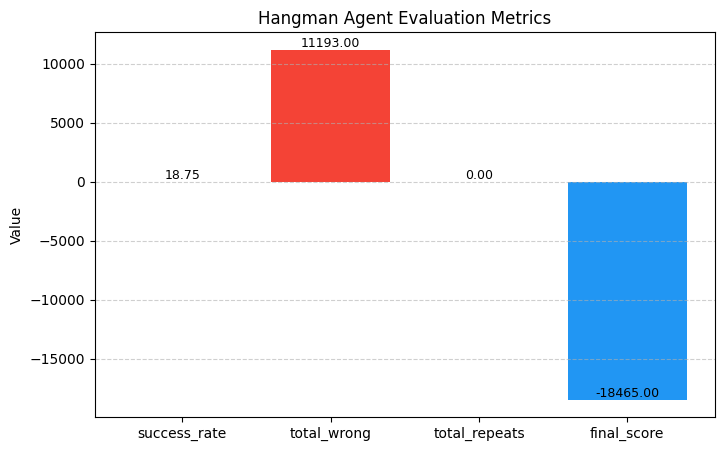


📊 Evaluation Summary:
success_rate   : 18.75
wins           : 375
total_games    : 2000
total_wrong    : 11193
total_repeats  : 0
final_score    : -18465.0


In [11]:
# === Block 7: Save & Plot Evaluation ===

import pickle
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Save Q-agent safely ---
try:
    with open('/content/qagent.pkl', 'wb') as f:
        pickle.dump(dict(agent.Q), f)
    print('💾 Agent Q-table saved to /content/qagent.pkl')
except Exception as e:
    print('⚠️ Could not save Q-table:', e)

# --- 2. Show top Q-values for a sample state ---
# Works only for tabular Q-learning agent; skip if DQN-based
if hasattr(agent, "Q") and len(agent.Q) > 0:
    sample_state = list(agent.Q.keys())[0]  # pick a random state from memory
    qvec = agent.Q[sample_state]
    letters = [chr(ord('a') + i) for i in range(26)]
    topk = np.argsort(-np.array(qvec))[:8]
    print(f"\n🔎 Top Q-values for sample state {sample_state}:")
    for i in topk:
        print(f"  {letters[i]} : {float(qvec[i]):.4f}")
else:
    print("\nℹ️ No Q-table found (likely using DQN or policy-based agent).")

# --- 3. Plot overall evaluation metrics ---
if 'eval_stats' in locals():
    metrics = ['success_rate', 'total_wrong', 'total_repeats', 'final_score']
    values = [eval_stats[m] for m in metrics]

    plt.figure(figsize=(8,5))
    bars = plt.bar(metrics, values, color=['#4caf50', '#f44336', '#ff9800', '#2196f3'])
    plt.title('Hangman Agent Evaluation Metrics')
    plt.ylabel('Value')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Annotate bars
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=9)

    plt.show()

    # Optional: show scaled results in a summary table
    print("\n📊 Evaluation Summary:")
    for k, v in eval_stats.items():
        print(f"{k:15s}: {v}")
else:
    print("\n⚠️ No eval_stats dictionary found. Please run evaluation block first.")
